# Estimate the activity rising time from calcium traces

This is a simple script to estimate the rising time of calcium traces. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
from scipy.signal import savgol_filter
from scipy import stats
import matplotlib.colors as mcolors
import statsmodels.api as sm


%matplotlib inline

In [2]:
data_file = './data/calcium_data_1205.xlsx'

# this is a excel with multiple sheets, open it with pandas
data = pd.ExcelFile(data_file)
sheet_names = data.sheet_names
print(sheet_names)

Text(0.5, 1.0, 'Normalized Calcium Data')

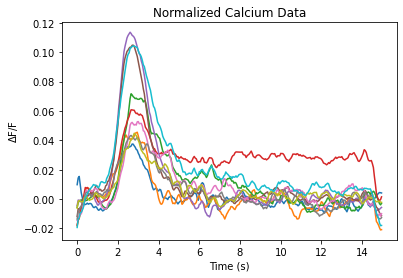

In [4]:
# get the data in the first sheet, no colum names, no index column
df1= data.parse(sheet_names[2], header=None, index_col=None)
time_step = 0.05 # 50 ms
pre_time = 1
pre_steps = int(pre_time/time_step)

times = time_step*np.arange(df1.shape[0])

# calculate the mean and std of the first 1s
pre_mean = df1.iloc[:pre_steps].mean()
pre_std = df1.iloc[:pre_steps].std()

# normalize the data by subtracting the mean and dividing by the mean
df1_norm = (df1 - pre_mean)/pre_mean

# make a plot of the normalized data
plt.figure()
plt.plot(times,df1_norm)
plt.xlabel('Time (s)')
plt.ylabel(r'$\Delta$F/F')
plt.title('Normalized Calcium Data')


Text(0.5, 1.0, 'Smoothed Calcium Data')

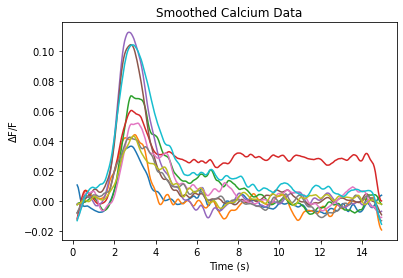

In [9]:
# for the above curve, smooth it with a moving average filter
# the window size is 10
window_size = 5
df1_norm_smooth = df1_norm.rolling(window_size).mean()
# make a plot of the smoothed data
plt.figure()
plt.plot(times,df1_norm_smooth)
plt.xlabel('Time (s)')
plt.ylabel(r'$\Delta$F/F')
plt.title('Smoothed Calcium Data')


In [11]:
time_step = 0.05 # 50 ms
pre_time = 1
pre_steps = int(pre_time/time_step)

window_size = 10
threshold_scale = 2 # 2 std above the mean
fig_pre = './figures/calcium_trace_' + str(window_size) + '_' + str(threshold_scale) + '_'


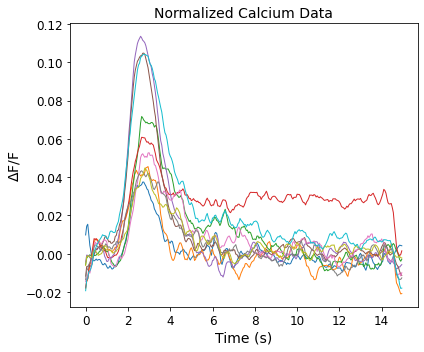

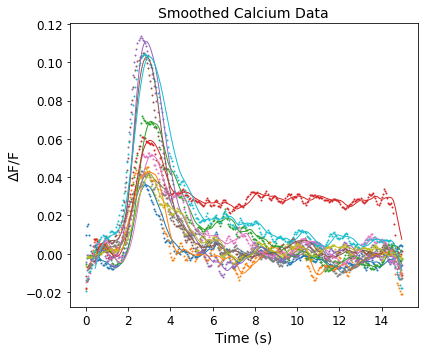

In [12]:
# get the raw data from each sheet

df1= data.parse(sheet_names[2], header=None, index_col=None)

times = time_step*np.arange(df1.shape[0])


def plot_trace_smooth(df1, window_size, fig_pre):
    # calculate the mean and std of the first 1s
    pre_mean = df1.iloc[:pre_steps].mean()
    pre_std = df1.iloc[:pre_steps].std()

    # normalize the data by subtracting the mean and dividing by the mean
    df1_norm = (df1 - pre_mean)/pre_mean

    # smooth curve with a moving average filter
    df1_norm_smooth = df1_norm.rolling(window_size).mean()

    # make a plot of the smoothed data
    plt.figure(figsize=(6,5))
    # add original data points, with symbol dots
    plt.plot(times,df1_norm,'.',markersize=2)
    plt.plot(times,df1_norm_smooth,linewidth=1)
    plt.xlabel('Time (s)',fontsize=14)
    plt.ylabel(r'$\Delta$F/F', fontsize=14)
    plt.title('Smoothed Calcium Data',fontsize=14)
    # set x and y axis font size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    # save the figure
    fig_name = fig_pre + 'smoothed.pdf'
    plt.savefig(fig_name,dpi=300)
    return df1_norm_smooth


### Function to estimate the rising time and slope at middle point

In [72]:
# from scipy.interpolate import UnivariateSpline
def trace_analysis(trace,fig_pre,times, number, wid_len=21, poly_order=3, threshold_scale=2, plog_flag = True):
    ''' Analyze the calcium trace, define the peak time, slope, and threshold time
    Input:
        trac: a pandas series, calcium trace
        fig_pre: figure name prefix
        times: time points
        number: index of the region in one sheet
        wid_len: window length for Savitzky-Golay filter
        poly_order: polynomial order for Savitzky-Golay filter
        threshold_scale: threshold scale, default is 2 fold of std
    '''
    # trace = df1_norm.iloc[:,0]
    # spl = UnivariateSpline(times, trace)
    try:
        # smooth the curve with a Savitzky-Golay filter
        y_filtered = savgol_filter(trace, window_length=wid_len, polyorder=poly_order)
    except:
        print('Savitzky-Golay filter failed, use lowess filter')
        lowess = sm.nonparametric.lowess(trace, times, frac=0.1)
        y_filtered = lowess[:,1]
        times = lowess[:,0]
        print('Time point changes!')

    # find the start time based on threshold
    pre_mean = np.mean(y_filtered[:pre_steps])
    pre_std = np.std(y_filtered[:pre_steps])
    data_range = y_filtered[pre_steps:]
    threshold = pre_mean + threshold_scale*pre_std

    # find the time points that are above the threshold
    try:
        index_thd= next(i for i, element in enumerate(data_range) if element >= threshold)
    except StopIteration as e:
        index_thd = None
        print("StopIteration caught")
    if index_thd is not None:
        time_threshold = times[index_thd + pre_steps]
    else:
    # Handle the case when no element in data_range is greater than threshold
        time_threshold = None
    # time_threshold = times[index_thd+pre_steps]

    # select a time window to analyze the peak and slope
    time_window = [int(1/time_step),int(8/time_step)]
    # find the maximum value of the smoothed curve in the time window between 1s and 8 s
    peak = max(y_filtered[time_window[0]:time_window[1]])
    peak_index = next(i for i, element in enumerate(y_filtered) if element == peak)
    peak_time = times[peak_index]

    mid_peak = peak/2
    # find the first time point that is above the threshold
    # y_filtered_sel = y_filtered[time_window[0]:time_window[1]]
    y_filtered_sel = y_filtered[time_window[0]:peak_index]
    # find the last time point that y_filtered_sel is below mid_peak
    # flag = y_filtered_sel < mid_peak
    # find the last index of flag that is Ture
    # index = last_index_smaller_than(y_filtered_sel, mid_peak)
    try:
        index = next(i for i, element in enumerate(y_filtered_sel[::-1]) if element <= mid_peak)
        mid_time = times[peak_index - index]
    except StopIteration as e:
        index = len(y_filtered_sel)
        mid_time = times[time_window[0]]
        print("StopIteration caught, use 1s as the middle point")

    # seelct 7 data point around the middle peak point
    # time_sel = times[time_window[0]+index - 3 : time_window[0]+index + 4]
    # y_sel = y_filtered[time_window[0]+index - 3 : time_window[0]+index + 4]
    time_sel = times[peak_index - index - 3 : peak_index - index + 4]
    y_sel = y_filtered[peak_index - index - 3 : peak_index - index + 4]
    # fit a line to the data points
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_sel,y_sel)
    if p_value > 0.01:
        print('p value is larger than 0.01, the slope is not significant')

    # estimate the 2nd derivative at the middle of the peak
    time_sel_mid = times[pre_steps:peak_index]
    y_sel_mid = y_filtered[pre_steps:peak_index]
    derivative = np.gradient(y_sel_mid, time_sel_mid)
    derivative2 = np.gradient(derivative, time_sel_mid)
    # find the index of the largest 2nd derivative
    index = np.argmax(derivative2)
    # find the time point of the largest 2nd derivative
    max2d_time = time_sel_mid[index]

    # xs = np.linspace(times[0], times[-1], 1000)
    if plog_flag:
        colors = mcolors.TABLEAU_COLORS
        fig, ax = plt.subplots(1,1,figsize=(6,4))
        # plt.figure(figsize=(6,4))
        plt.plot(times,trace,'o',markersize=2, color='gray',alpha=0.5)
        # spl.set_smoothing_factor(0.2)
        plt.plot(times, y_filtered, 'black', lw=1.5)
        # mark the mid peak with a star
        if mid_time is not None:
            plt.plot(mid_time, mid_peak, '*', markersize=10, color='red')
        # add a vertical dashed line at the mid peak time
            plt.axvline(mid_time,linestyle='--',color='blue', linewidth=1,label='mid peak')
        # add a vertical line at the maximum 2nd derivative time
        plt.axvline(max2d_time,linestyle='--',color='orange', linewidth=1, label='max 2nd derivative')
        # add a vertical line at the threshold time
        if time_threshold is not None:
            plt.axvline(time_threshold,linestyle='--',color='green', linewidth=1,label='threshold')

        # add slope value as text
        plt.text(0.5, 0.8, 'slope = {:.3f}'.format(slope), fontsize=14,
        color='black', transform=ax.transAxes)
        plt.text(0.5, 0.7, 'p_value = {:.4E}'.format(p_value), fontsize=14,
        color='black', transform=ax.transAxes)
        plt.xlabel('Time (s)', fontsize=20)
        plt.ylabel(r'$\Delta$F/F',fontsize=20)
        plt.title('ROI {}'.format(number+1),fontsize=20) # ROI index starts from 1
        # set the x and y axis font size
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        # save the figure
        fig_name = fig_pre + '_#' + str(number) + '.pdf'
        # plt.title('Smoothed Calcium Data')
        # save the figure
        plt.savefig(fig_name,dpi=300)

    return mid_time, max2d_time, time_threshold, slope, peak

### Analyzing and summarize all the calcium traces

In [74]:
# get the raw data from each sheet
# define a data frame to store the results
df = pd.DataFrame({'mid_time':[],'max2d_time':[],'time_threshold':[],'slope':[], 'peak':[]})

for names in sheet_names:
    df1= data.parse(names, header=None, index_col=None)
    times = time_step*np.arange(df1.shape[0])

    # calculate the mean and std of the first 1s
    pre_mean = df1.iloc[:pre_steps].mean()
    pre_std = df1.iloc[:pre_steps].std()

    # normalize the data by subtracting the mean and dividing by the mean
    df1_norm = (df1 - pre_mean)/pre_mean
    total_cols = df1_norm.shape[1]

    fig_pre = './figures/calcium_trace_' + names + '_thd_' + str(threshold_scale) + '_'

    # plot orignial and smoothed data

    # analyze each trace
    row_names = []
    mid_times = []
    max2d_times = []
    time_thresholds =[]
    slopes = []
    peaks = []
    for i in range(total_cols):
        trace = df1_norm.iloc[:,i]
        mid_time, max2d_time, time_threshold, slope, peak = trace_analysis(trace,fig_pre,times,i,plog_flag=False)
    # write mid_time, max2d_time, time_threshold, slope to a csv file, one sheet one file
        row_names.append(names + '_' + str(i))
        mid_times.append(mid_time)
        max2d_times.append(max2d_time)
        time_thresholds.append(time_threshold)
        slopes.append(slope)
        peaks.append(peak)
    df_curr = pd.DataFrame({'mid_time':mid_times,'max2d_time':max2d_times,'time_threshold':time_thresholds,
                            'slope':slopes, 'peak':peaks},index=row_names)
    # df_curr.index = row_names
    df = df.append(df_curr)
# save the final cvs file
df.to_csv('./results/calcium_trace_summary.csv',index=True)


StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught
StopIteration caught, use 1s as the middle point
StopIteration caught


In [46]:
def last_index_smaller_than(vector, value):
    last_index = None
    for i, element in enumerate(vector):
        if element <= value:
            last_index = i
    return last_index

## Trouble-shooting

Text(0.5, 1.0, 'Smoothed Calcium Data')

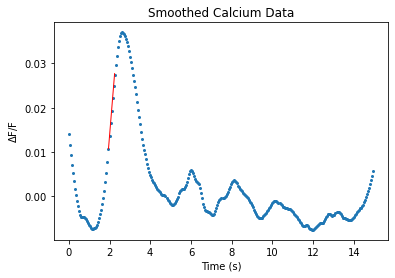

In [34]:
from scipy import stats
# seelct 7 data point around the middle peak point
time_sel = times[time_window[0]+index - 3 : time_window[0]+index + 4]
y_sel = y_filtered[time_window[0]+index - 3 : time_window[0]+index + 4]
# fit a line to the data points
slope, intercept, r_value, p_value, std_err = stats.linregress(time_sel,y_sel)

# plot the data points and the fitted line
plt.figure()
plt.plot(times, y_filtered,'o',markersize=2)
plt.plot(time_sel, slope*time_sel + intercept, 'r', lw=1)
plt.xlabel('Time (s)')
plt.ylabel(r'$\Delta$F/F')
plt.title('Smoothed Calcium Data')


Text(0.5, 0, 'Time (s)')

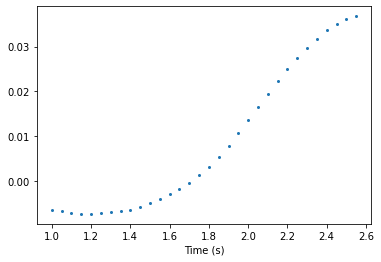

In [35]:
# use the smoothed data in the range between 1 s and peak time
time_sel = times[pre_steps:peak_index]
y_sel = y_filtered[pre_steps:peak_index]
# plot
plt.figure()
plt.plot(time_sel, y_sel,'o',markersize=2)
# plt.plot(time_sel, slope*time_sel + intercept, 'r', lw=1)
plt.xlabel('Time (s)')

Text(0.5, 1.0, 'Smoothed Calcium Data')

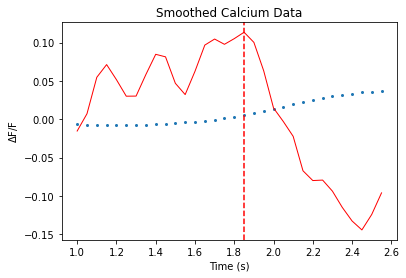

In [37]:
# find the location of largest 2nd derivative
derivative = np.gradient(y_sel, time_sel)
derivative2 = np.gradient(derivative, time_sel)
# find the index of the largest 2nd derivative
index = np.argmax(derivative2)
# find the time point of the largest 2nd derivative
time_cross = time_sel[index]
# plot the data points and the fitted line
plt.figure()
plt.plot(time_sel, y_sel,'o',markersize=2)
plt.plot(time_sel, derivative2, 'r', lw=1)
# add a vertical line to indicate the time point of the largest 2nd derivative
plt.axvline(time_cross,linestyle='--',color='r')

plt.xlabel('Time (s)')
plt.ylabel(r'$\Delta$F/F')
plt.title('Smoothed Calcium Data')
